In [2]:
%matplotlib inline

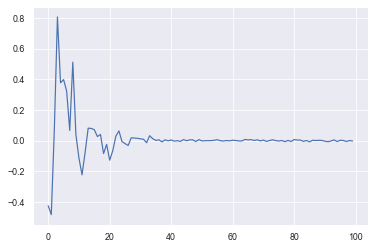

In [26]:
from utilities import GaussianNoise

import matplotlib.pyplot as plt

n = GaussianNoise(1, 42, 0, .4, .1, 1, 0.01)

x = [n.sample() for s in range(1000)]

plt.plot(x[:100])

# Multi Agent RL

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. Reinforcement Learning Algorithm

The algorityhm used is the DDPG Agent as described by the [DDPG Paper](https://arxiv.org/pdf/1509.02971) and the code provided on [Udacity's DRLND Github Repository](https://github.com/udacity/deep-reinforcement-learning#dependencies). The Agent combined a policy based and values based approach, known as Actor-Critic method.

This algorithm uses an Actor-Critic approach, which the Critic is used to approximate the maximizer over the "Q-values" of the next state and not a learned baseliner (such as A2C). The Actor learns a deterministic policy to select the best action given the states. the algorithm has two interesting aspects:
- **Soft Updates**: Instead of updating the target/regular networks weights every `C` timesteps, weights are gradually mixed (generally 0.01-0.001%) at every timestep.
- **Replay  Buffer**: Samples thes sequences of S.A.R.S' randomly, therefore reducing the high correlations between these sequences.


All these logic are implemented on the files `model.py` and `ddpg_agent.py`.
Some hyperparameters are also listed on the file `ddpg_agent.py`

### 3. MADDPG Agent

The next cell implements the DDPG Agent on the Unity Environment.

In [9]:
# Hyperparameters
PARAMETERS = {
    'BUFFER_SIZE': int(1e7),          # Replay buffer size
    'BATCH_SIZE': 256,                # Minibatch size
    'GAMMA': 1.,                      # Discount factor
    'TAU': 1e-2,                      # Soft update of target parameters
    'UPDATE_EVERY': 1,                # Wait for more experiences before update

    'N_AGENTS': 2,                    # Total number of agents
    'STATE_SIZE': 24,                 # Size of the state for each agent
    'ACTION_SIZE': 2,                 # Size of actions for each agent

    'ACTOR_LR': 1e-3,                 # Learning rate of the actor
    'ACTOR_WEIGHT_DECAY': 0.0000,     # Actor L2 weight decay
    'ACTOR_GRADIENT_CLIP_VALUE': 2,   # Max gradient modulus for clipping

    'CRITIC_LR': 1e-3,                # Learning rate of the critic
    'CRITIC_WEIGHT_DECAY': 0.0001,    # Critic L2 weight decay
    'CRITIC_GRADIENT_CLIP_VALUE': 5,  # Max gradient modulus for clipping

    'NOISE_TYPE': 'ou',               # Type of noise used: 'normal' or 'ou'
    'N_SIGMA': .4,                    # Normal noise sigma parameters

    'OU_THETA': .002,                   # OU noise theta parameter
    'OU_SIGMA': .002,                  # OU noise sigma parameters

    'SEED': 42,                       # Random seed
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [10]:
# Load and define agent
from maddpg import MADDPG

agent = MADDPG(PARAMETERS)

In [11]:
# Hyperparameters
N_EPISODES = 1000
MAX_T = 1000
SUCCESS_SCORE = .5

In [12]:
from utilities import train_MADDPG

scores = train_MADDPG(env, agent, n_episodes=N_EPISODES, max_t=MAX_T,
                      success_score=SUCCESS_SCORE, print_every=100)

Episode 100/1000	Average Score (last 100): 0.0029	 Last score: 0.0000
Episode 200/1000	Average Score (last 100): 0.0038	 Last score: 0.0000
Episode 300/1000	Average Score (last 100): 0.0068	 Last score: 0.0000
Episode 400/1000	Average Score (last 100): 0.0020	 Last score: 0.0000
Episode 455/1000	Average Score (last 100): 0.0030	 Last score: 0.0000

KeyboardInterrupt: 

### 5. Rewards

In [12]:
import matplotlib.pyplot as plt

# Plot rewards
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
ax

### 6. Check the Trained Agent

In [13]:
# load the weights from file
agent.actors_local[0].load_state_dict(torch.load('Actor1_checkpoint.pth'))
agent.actors_local[1].load_state_dict(torch.load('Actor2_checkpoint.pth'))
agent.critic_local.load_state_dict(torch.load('Critic_checkpoint.pth'))

# Use the trained agent for 1 episodes
for i in range(1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    states = env_info.vector_observations            # get the current state
    score = 0    
    while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]                 # perform actions
        next_states = env_info.vector_observations               # get the next states
        rewards = np.array(env_info.rewards).reshape(-1, 1)      # get the rewards
        dones = np.array(env_info.local_done).reshape(-1, 1)     # see if episode has finished
        agent.step(states, actions, rewards, next_states, dones)
        states = next_states
        score += sum(rewards)
        if dones.any():
            break

NameError: name 'np' is not defined

When finished, you can close the environment.

In [ ]:
env.close()

### 7. Future Improvements

Implement these methods to improve learning performance:

- Extract some improvements from the [Rainbow](https://arxiv.org/pdf/1710.02298.pdf) architecture such as:
    - Prioritized Experience
    - Multi-step learning
    - Noisy Nets